In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import linregress

In [31]:
yf_data = yf.download('F', start="1800-01-01")
yf_data.reset_index(inplace=True)
yf_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,F,F,F,F,F,F
0,1972-06-01 00:00:00+00:00,0.226079,2.153220,2.173495,2.149165,0.000000,1091238
1,1972-06-02 00:00:00+00:00,0.225653,2.149165,2.173495,2.141055,2.153220,1174468
2,1972-06-05 00:00:00+00:00,0.225653,2.149165,2.169440,2.141055,2.149165,5209582
3,1972-06-06 00:00:00+00:00,0.223099,2.124835,2.157275,2.116725,2.149165,1424158
4,1972-06-07 00:00:00+00:00,0.221821,2.112670,2.137000,2.112670,2.124835,675088


In [32]:
# Daily returns calculations
data = yf_data[["Date", "Adj Close"]]
data.set_index("Date", inplace=True)
data = data.rename(columns={"Adj Close": "Ford stock price"})
data["Daily returns"] = data["Ford stock price"].pct_change()*100
data = data.loc[data["Daily returns"] != 0]

# Volatility calculations
rolling_window = 20
data["Rolling Mean"] = data["Daily returns"].rolling(window=rolling_window).mean()
data["Rolling Variance"] = data["Daily returns"].rolling(window=rolling_window).apply(
    lambda x: ((x - x.mean()) ** 2).sum() / (len(x) - 1), raw=True
)
data["Volatility"] = data["Rolling Variance"] ** 0.5
data.drop(columns=["Rolling Mean", "Rolling Variance"], inplace=True)

# Drop NA rows
data.dropna(axis=0, how="any", inplace=True)

data

Price,Ford stock price,Daily returns,Volatility
Ticker,F,,
Date,,,
1972-07-03 00:00:00+00:00,0.216712,-0.391447,0.665888
1972-07-05 00:00:00+00:00,0.215435,-0.589323,0.671240
1972-07-06 00:00:00+00:00,0.217990,1.185778,0.706345
1972-07-07 00:00:00+00:00,0.217138,-0.390689,0.701277
1972-07-10 00:00:00+00:00,0.214583,-1.176430,0.727102
...,...,...,...
2024-12-10 00:00:00+00:00,10.560000,-0.377358,1.743549
2024-12-11 00:00:00+00:00,10.410000,-1.420460,1.764213


<Figure size 1200x600 with 0 Axes>

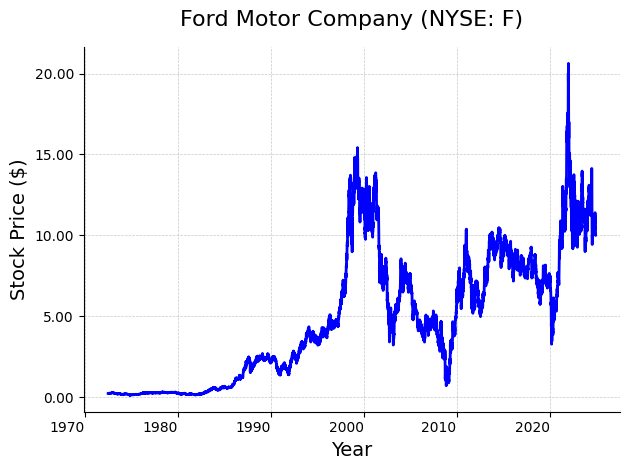

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Set a modern style
plt.style.use('seaborn-v0_8-muted')  # Or use 'ggplot', 'seaborn-darkgrid', etc.

# Create the figure
plt.figure(figsize=(12, 6))

# Plot the stock price
data.plot(y='Ford stock price', legend=False, color='blue', linewidth=2)

# Add title and labels
plt.title('Ford Motor Company (NYSE: F)', fontsize=16, pad=15)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Stock Price ($)', fontsize=14)

# Format y-axis to display as currency
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.2f}'))

# Set x-axis tick labels rotation to 0 (horizontal)
plt.xticks(rotation=0)

# Add subtle gridlines
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a border around the graph
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display the plot
plt.tight_layout()
plt.show()


In [35]:
print(f"Mean daily return is {round(data['Daily returns'].mean(), 5)}%")
print(f"Mean volatility over stock returns is {round(data['Volatility'].mean(), 5)}")

print(f"\nAnnualized mean daily return is {round(data['Daily returns'].mean()*252, 5)}%")
print(f"Annualized mean volatility over stock returns is {round(data['Volatility'].mean()*(252**0.5), 5)}")

Mean daily return is 0.05728%
Mean volatility over stock returns is 2.05084

Annualized mean daily return is 14.4344%
Annualized mean volatility over stock returns is 32.55606


In [38]:
## Getting

data['YearMonth'] = data.index.to_period('M')
monthly_variance = data.groupby('YearMonth')['Daily returns'].var()/100
monthly_variance.index = monthly_variance.index.to_timestamp()

# Compute Monthly Stock Price Change (Delta S)
monthly_prices = data.groupby('YearMonth')['Ford stock price'].last()
monthly_price_change = monthly_prices.diff()

# Compute Monthly Variance Change (Delta Variance)
monthly_variance_change = monthly_variance.diff()

# Estimate \rho (Correlation)
correlation_rho = np.corrcoef(monthly_price_change[1:].values.ravel(), monthly_variance_change[1:].values)[0, 1]

variance_lagged = monthly_variance[:-1]
variance_next = monthly_variance[1:]

delta_variance = variance_next.values - variance_lagged.values
slope, intercept, r_value, p_value, std_err = linregress(variance_lagged.values, delta_variance)

# \kappa is the negative of the slope
kappa_reg = -slope

# \theta is the intercept divided by \kappa
if kappa_reg != 0:
    theta_reg = intercept / kappa_reg
else:
    theta_reg = np.nan

print(correlation_rho)
print(kappa_reg)
print(theta_reg)

-0.06973720301379471
0.30862323350074816
0.052769460666949305


C:\Users\nikhi\AppData\Local\Temp\ipykernel_17788\1531354220.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['YearMonth'] = data.index.to_period('M')


## TASK 2 -> GBM and Heston Models

0.32556062267114183


(0.0, 40.0)

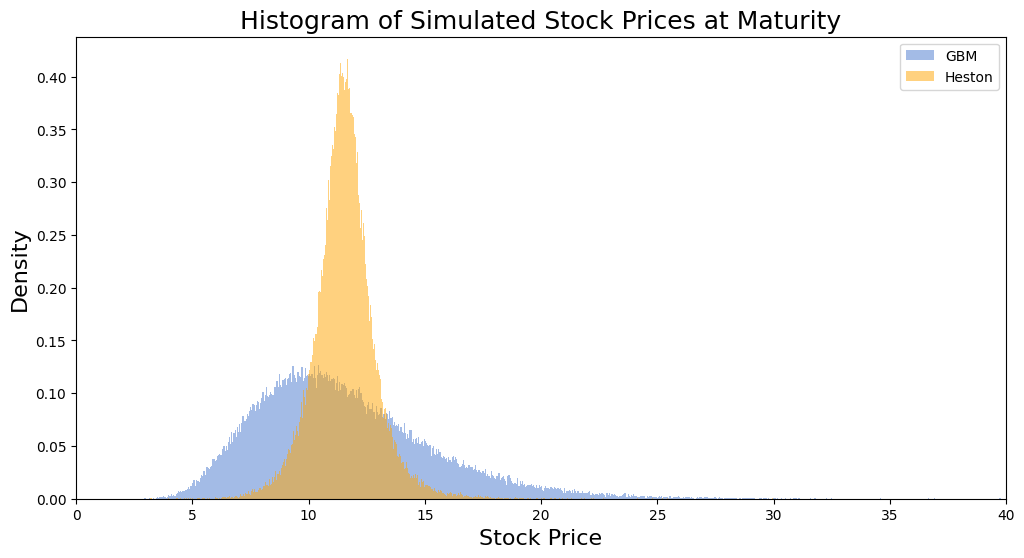

In [112]:
# Parameters
S0 = data["Ford stock price"].iloc[-1] # Initial stock price
S0 = float(S0.iloc[0])
alpha = (data['Daily returns'].mean()*252)/100  # Mean annualized return (drift)
# alpha = 0
sigma = data['Volatility'].mean()*(252**0.5)/100  # Annualized volatility
print(sigma)
dt = 1/252  # Time step (1 trading day)
T = 1  # Total time (1 year)
N = int(T / dt)  # Number of time steps (252 days)
simulations = 100000  # Number of simulated paths

# Geometric Brownian Motion Simulation
np.random.seed(42)  # Set seed for reproducibility
random_numbers = np.random.normal(0, 1, (simulations, N))  # Generate standard normal random numbers
dW = random_numbers * np.sqrt(dt)  # Scale random numbers by sqrt(dt) for Brownian motion
W = np.cumsum(dW, axis=1)  # Compute cumulative sum along time axis for Brownian motion
t = np.arange(1, N+1) * dt  # Time points for the simulation
drift = (alpha - 0.5 * sigma**2) * t  # Compute the deterministic drift component of GBM
stock_paths_gbm = S0 * np.exp(sigma * W + drift)  # Compute GBM stock price paths

# Extract stock prices at maturity
stock_prices_gbm = stock_paths_gbm[:, -1]  # Final stock prices for each path at maturity (T)

xi = 0.3  # Volatility of variance
kappa = kappa_reg  # Rate of mean reversion
theta = theta_reg  # Long-run variance
rho = correlation_rho  # Correlation between stock price and variance
v0 = sigma**2  # Initial variance, squared GBM volatility

# Heston Model Parameters
#xi = 0.3  # Volatility of variance
#kappa = 2.0  # Rate of mean reversion
#theta = 0.04  # Long-run variance
#rho = -0.7  # Correlation between stock price and variance
#v0 = sigma**2  # Initial variance, squared GBM volatility

# Heston Model Simulation
v = np.full((simulations, N), v0)  # Initialize variance paths with the initial variance
random_numbers_1 = np.random.normal(0, 1, (simulations, N))  # Independent normal random numbers for W_S
random_numbers_2 = np.random.normal(0, 1, (simulations, N))  # Independent normal random numbers for W_V
dW_S = random_numbers_1 * np.sqrt(dt)  # Scale random numbers for stock price Brownian motion
dW_V = rho * random_numbers_1 * np.sqrt(dt) + np.sqrt(1 - rho**2) * random_numbers_2 * np.sqrt(dt)
# Create correlated Brownian motion for variance using rho

# Simulate variance and enforce non-negativity
for i in range(1, N):  # Iterate over time steps
    v[:, i] = v[:, i-1] + kappa * (theta - v[:, i-1]) * dt + xi * np.sqrt(np.maximum(v[:, i-1], 0)) * dW_V[:, i-1]
    # Update variance based on Heston stochastic variance formula
    v[:, i] = np.maximum(v[:, i], 0)  # Ensure variance stays non-negative

# Initialize stock paths
stock_paths_heston = np.zeros((simulations, N))
stock_paths_heston[:, 0] = S0  # Initial stock price

for i in range(1, N):
    stock_paths_heston[:, i] = stock_paths_heston[:, i-1] * np.exp(
        v[:, i-1] * dW_S[:, i-1] - 0.5 * v[:, i-1]**2 * dt + alpha * dt
    )

# Compute Heston stock price paths using stochastic volatility

# Extract stock prices at maturity
stock_prices_heston = stock_paths_heston[:, -1]  # Final stock prices for each path at maturity (T)

# Histograms
bins = 1000  # Number of bins for the histogram
plt.figure(figsize=(12, 6))  # Create a figure with specified size

plt.hist(stock_prices_gbm, bins=bins, alpha=0.5, label='GBM', density=True)
# Plot histogram for GBM stock prices
plt.hist(stock_prices_heston, bins=bins, alpha=0.5, label='Heston', density=True, color='orange')
# Plot histogram for Heston stock prices
plt.title("Histogram of Simulated Stock Prices at Maturity", fontsize=18)  # Add a title to the plot
plt.xlabel("Stock Price", fontsize=16)  # Label the x-axis
plt.ylabel("Density", fontsize=16)  # Label the y-axis
plt.legend()  # Add a legend to distinguish GBM and Heston
plt.xlim(0,40)

## Task 3
GBM Z(T)=exp(−α−rσW(T)−12(α−rσ)2T)

Heston model Z(T)=exp(−∫T0α−rv(t)√dW(t)−12∫T0(α−rv(t)√)2dt)

In [116]:

### Compute Z(T) for GBM

r = 0.04598

# Take Brownian motion at the last step
W_T = W[:, -1]

# Insert into the formula
Z_T_GBM = np.exp(-((alpha - r) / sigma) * W_T - 0.5 * ((alpha - r) / sigma)**2 * T)
mean_Z_T_GBM = np.mean(Z_T_GBM)
print(f"Mean of Z(T) for GBM: {mean_Z_T_GBM}")

correlation_Z_T_GBM = np.corrcoef(Z_T_GBM, stock_prices_gbm)[0, 1]
print(f"Correlation between Z(T) and S(T) for GBM: {correlation_Z_T_GBM}")
### Compute Z(T) for the Heston Model
# Compute Z(T) for stochastic volatility model
Z_T_heston = np.exp(-np.cumsum((alpha - r) / np.sqrt(np.maximum(v, 1e-8)) * dW_S, axis=1)[:, -1] - 0.5 * np.cumsum(((alpha - r) / np.sqrt(np.maximum(v, 1e-8)))**2 * dt, axis=1)[:, -1])

mean_Z_T_heston = np.mean(Z_T_heston)
print(f"\nMean of Z(T) for Heston: {mean_Z_T_heston}")

correlation_Z_T_heston = np.corrcoef(Z_T_heston, stock_prices_heston)[0, 1]
print(f"Correlation between Z(T) and S(T) for Heston: {correlation_Z_T_heston}")

### Divide into bins
stock_bins_GBM = np.linspace(stock_prices_gbm.min(), stock_prices_gbm.max(),bins + 1)
stock_bins_heston = np.linspace(stock_prices_heston.min(), stock_prices_heston.max(),bins + 1)


### GBM
bin_indices_GBM = np.digitize(stock_prices_gbm, stock_bins_GBM)
mean_Z_per_bin_GBM = np.array([np.mean(Z_T_GBM[bin_indices_GBM == i])
  if np.sum(bin_indices_GBM == i) > 0 else 0
  for i in range(1, len(stock_bins_GBM))
])
physical_prob_GMB = np.array([np.sum(bin_indices_GBM == i) / simulations for i in range(1, len(stock_bins_GBM))])
risk_neutral_prob_GBM = physical_prob_GMB * mean_Z_per_bin_GBM

### Heston
bin_indices_heston = np.digitize(stock_prices_heston, stock_bins_heston)
mean_Z_per_bin_heston = np.array([np.mean(Z_T_heston[bin_indices_heston == i])
  if np.sum(bin_indices_heston == i) > 0 else 0
  for i in range(1, len(stock_bins_heston))
])
physical_prob_heston = np.array([np.sum(bin_indices_heston == i) / simulations for i in range(1, len(stock_bins_heston))])
risk_neutral_prob_heston = physical_prob_heston * mean_Z_per_bin_heston

### Compute stock price under Risk-Neutral measure
stock_bins_centers_GBM = (stock_bins_GBM[:-1] + stock_bins_GBM[1:]) / 2
stock_bins_centers_heston = (stock_bins_heston[:-1] + stock_bins_heston[1:]) / 2

expected_stock_price_GBM = np.sum(risk_neutral_prob_GBM * stock_bins_centers_GBM)
expected_stock_price_heston = np.sum(risk_neutral_prob_heston * stock_bins_centers_heston)

print(f"\Risk Neutral probs for GBM {risk_neutral_prob_GBM}")
print(f"\Phyical probs for GBM {physical_prob_GMB}")
print(f"\Risk Neutral probs for Heston {risk_neutral_prob_heston}")
print(f"\Phyical probs for GBM {physical_prob_heston}")

print(f"\nExpected stock price for GBM {expected_stock_price_GBM}")
print(f"Expected stock price for the Heston model {expected_stock_price_heston}")

print(f"\nExpected stock return for GBM {expected_stock_price_GBM / S0}")
print(f"Expected stock return for the Heston model {expected_stock_price_heston / S0}")

Mean of Z(T) for GBM: 1.0000849201037934
Correlation between Z(T) and S(T) for GBM: -0.9050140428388527

Mean of Z(T) for Heston: 0.9360111265877371
Correlation between Z(T) and S(T) for Heston: -0.47034509700041344
\Risk Neutral probs for GBM [4.28832029e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.41012877e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.65031917e-05 3.17945265e-05 0.00000000e+00 3.06860328e-05
 6.05544521e-05 0.00000000e+00 0.00000000e+00 2.90350383e-05
 8.61881936e-05 2.82727544e-05 1.39946477e-04 2.48693813e-04
 1.09217495e-04 1.88691036e-04 1.86300905e-04 1.84310045e-04
 2.07730059e-04 3.33790987e-04 2.28350849e-04 1.25502239e-04
 1.98594786e-04 3.67762615e-04 3.39507353e-04 3.12231555e-04
 5.22068162e-04 3.29017874e-04 3.71932334e-04 3.22080343e-04
 5.00432420e-04 6.08073707e-04 8.02100545e-04 6.62146209e-04
 7.64157340e-04 6.929997

## Task 4
Pricing a Plain-Vanilla Option Under Each Stochastic Process – 20% of marks 

In [120]:
# Parameters
K = 12                 # Higher, close to initial stock price
paths = simulations    # Number of simulations

#=============================================================
# Geometric Brownian Motion (GBM)
#=============================================================
# Step 3: Calculate the maturity payoff of option per bin
payoffs = np.maximum(stock_bins_centers_GBM - K, 0)

# Step 4: Multiply the maturity payoff by risk-neutral probabilities
weighted_payoffs = payoffs * risk_neutral_prob_GBM

# Step 5: Sum up the weighted payoffs
expected_payoff = np.sum(weighted_payoffs)

# Step 6: Discount back to PV
option_price = expected_payoff * np.exp(-r * T)

# Output the option price for GBM model
print(f"GBM European call option price: {option_price:.4f}")


#=============================================================
# Stochastic Volatility Model (Heston Model)
#=============================================================
# Step 3: Calculate the maturity payoff of option per bin
payoffs = np.maximum(stock_bins_centers_heston - K, 0)

# Step 4: Multiply the maturity payoff by risk-neutral probabilities
weighted_payoffs = payoffs * risk_neutral_prob_heston

# Step 5: Sum up the weighted payoffs
expected_payoff = np.sum(weighted_payoffs)

# Step 6: Discount back to PV
option_price = expected_payoff * np.exp(-r * T)

# Output the option price for Heston model
print(f"Heston European call option price: {option_price:.4f}")



#=============================================================
# Black-Scholes-Merton Model (BSM)
#=============================================================
# Calculate d1 & d2
d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

# CDF of standard normal for d1 & d2
N_d1 = norm.cdf(d1)  
N_d2 = norm.cdf(d2)  

# Calculate the option price using BSM formula
option_price = S0 * N_d1 - K * np.exp(-r * T) * N_d2

# Output the option price for BSM model
print(f"BS European call option price: {option_price:.4f}")


GBM European call option price: 0.7764
Heston European call option price: 0.1872
BS European call option price: 0.7818


Task 5

In [121]:
B=20

# =============================================================
# Additional code at the end (after all your existing code)
# =============================================================

# Barrier condition: If stock price at maturity > B, payoff = 0, else payoff = max(S-K,0)

# Compute payoffs taking into account the barrier
payoffs_gbm_barrier = np.where(stock_bins_centers_GBM > B, 0, np.maximum(stock_bins_centers_GBM - K, 0))

# Multiply the maturity payoff by the previously computed GBM risk-neutral probabilities
weighted_payoffs_gbm_barrier = payoffs_gbm_barrier * risk_neutral_prob_GBM

# Sum up the weighted payoffs to get the expected payoff under the risk-neutral measure
expected_payoff_gbm_barrier = np.sum(weighted_payoffs_gbm_barrier)

# Discount the expected payoff back to present value
option_price_gbm_barrier = expected_payoff_gbm_barrier * np.exp(-r * T)

# Print the up-and-out call option price
print(f"GBM Up-and-Out Call Option Price (from bins & RN probs): {option_price_gbm_barrier:.4f}")

# Barrier condition: If stock price at maturity > B, payoff = 0, else payoff = max(S-K,0) for Heston model
payoffs_heston_barrier = np.where(stock_bins_centers_heston > B, 0, np.maximum(stock_bins_centers_heston - K, 0))

# Multiply the maturity payoff by the previously computed Heston risk-neutral probabilities
weighted_payoffs_heston_barrier = payoffs_heston_barrier * risk_neutral_prob_heston

# Sum up the weighted payoffs to get the expected payoff under the risk-neutral measure
expected_payoff_heston_barrier = np.sum(weighted_payoffs_heston_barrier)

# Discount the expected payoff back to present value
option_price_heston_barrier = expected_payoff_heston_barrier * np.exp(-r * T)

# Print the up-and-out call option price for the Heston model
print(f"Heston Up-and-Out Call Option Price (from bins & RN probs): {option_price_heston_barrier:.4f}")

def d_plus(T, x, r, sigma):
    return (np.log(x) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))

def d_minus(T, x, r, sigma):
    return d_plus(T, x, r, sigma) - sigma*np.sqrt(T)

# From Shreve's formula (7.3.19):
# V(0) = S(0)[N(δ+(T, S(0)/K)) - N(δ+(T, S(0)/B))]
#      - e^{-rT}K [N(δ-(T, S(0)/K)) - N(δ-(T, S(0)/B))]
#      - B (S(0)/B)^{-2r/σ²+1} [N(δ+(T, B²/(K S(0)))) - N(δ+(T, B/S(0)))]
#      + e^{-rT}K (S(0)/B)^{-2r/σ²+1} [N(δ-(T, B²/(K S(0)))) - N(δ-(T, B/S(0)))]

def up_and_out_call_closed_form(S0, K, B, r, sigma, T):
    power = -2.0*r/(sigma**2) + 1.0

    # Precompute d+ and d- for required arguments
    # For convenience define a helper inline function
    def N_dplus(T, x): return norm.cdf(d_plus(T, x, r, sigma))
    def N_dminus(T, x): return norm.cdf(d_minus(T, x, r, sigma))
    
    term1 = S0 * (N_dplus(T, S0/K) - N_dplus(T, S0/B))
    term2 = - np.exp(-r*T)*K * (N_dminus(T, S0/K) - N_dminus(T, S0/B))
    term3 = - B * ((S0/B)**(power-1.0)) * (N_dplus(T, (B**2)/(K*S0)) - N_dplus(T, B/S0))
    term4 = np.exp(-r*T)*K*((S0/B)**power)*(N_dminus(T, (B**2)/(K*S0)) - N_dminus(T, B/S0))

    return term1 + term2 + term3 + term4

# Compute and print the closed-form solution
closed_form_value = up_and_out_call_closed_form(S0, K, B, r, sigma, T)
print(f"Closed-form Up-and-Out Call Option Price (Shreve): {closed_form_value:.4f}")


GBM Up-and-Out Call Option Price (from bins & RN probs): 0.6184
Heston Up-and-Out Call Option Price (from bins & RN probs): 0.1851
Closed-form Up-and-Out Call Option Price (Shreve): 0.5296
